# Conditional Linear Gaussian Model

In [1]:
import pandas as pd

from pearl.bayesnet import BayesianNetwork, from_yaml
from pearl.data import BayesianNetworkDataset, VariableData
from pearl.common import NodeValueType

import torch

import matplotlib.pyplot as plt

from pyro.optim import Adam

import graphviz

This notebook demonstrates the use of `pearl` to construct conditional linear gaussian BNs. A conditional linear gaussian Bayesian Network is the one where parents of discrete nodes are all discrete and continuous nodes use a conditional linear gaussian CPD. 

A conditional linear gaussign CPD defines a Normal distribution for each combination of discrete parents with a mean that is a linear combination of continuous parents and an independent variance.

We will use an example from the [bnlearn](https://www.bnlearn.com/bnrepository/) repository. Specifically we will use the [clgaussian.test](https://www.bnlearn.com/documentation/networks/index.html#clgaussian) hybrid network. This small graphical model has 8 random variables and the CPDs are a mix of discrete and conditional linear gaussians distributions. The dataset to test parameter learning is obtained from the bnlearn R package. It contains 5000 examples.

## Data pre-processing

First we will process the csv file and create a `BayesianNetworkDataset` and a train/test split.

In [2]:
df = pd.read_csv('clgaussian.csv')
print(f'length of the dataset: {len(df)}')
df.head()

length of the dataset: 5000


,Unnamed: 0,A,B,C,D,E,F,G,H
0,1,a,b,d,6.460721,11.986566,b,34.842461,2.334846
1,2,b,a,a,12.758389,30.436740,b,106.635964,2.359112
2,3,b,c,c,12.175140,17.215321,a,68.929510,2.319435
3,4,b,c,d,12.006609,14.416459,b,86.175208,2.417494
4,5,b,a,a,12.328071,30.396309,b,103.585413,2.268150


In [3]:
for col, categories in zip(['A', 'B', 'C', 'F'], [['a','b'], ['a','b','c'], ['a','b','c','d'], ['a','b']]):
    cat_dtype = pd.api.types.CategoricalDtype(categories=categories)
    df[col] = df[col].astype(cat_dtype)

In [4]:
variable_dict = {
    'A': VariableData(
        NodeValueType.CATEGORICAL,
        torch.tensor(df['A'].cat.codes).float(),
        ['a', 'b'],
    ),
    'B': VariableData(
        NodeValueType.CATEGORICAL,
        torch.tensor(df['B'].cat.codes).float(),
        ['a', 'b', 'c'],
    ),
    'C': VariableData(
        NodeValueType.CATEGORICAL,
        torch.tensor(df['C'].cat.codes).float(),
        ['a', 'b', 'c', 'd'],
    ),
    'D': VariableData(
        NodeValueType.CONTINUOUS,
        torch.tensor(df['D']).float(),
    ),
    'E': VariableData(
        NodeValueType.CONTINUOUS,
        torch.tensor(df['E']).float(),
    ),
    'F': VariableData(
        NodeValueType.CATEGORICAL,
        torch.tensor(df['F'].cat.codes).float(),
        ['a', 'b'],
    ),
    'G': VariableData(
        NodeValueType.CONTINUOUS,
        torch.tensor(df['G']).float(),
    ),    
    'H': VariableData(
        NodeValueType.CONTINUOUS,
        torch.tensor(df['H']).float(),
    )
}
dataset = BayesianNetworkDataset(variable_dict)

In [5]:
train_dataset, test_dataset = dataset.split((4000, 1000))

## Declarative definition of the graphical model

The graphical model shown in the bnlearn website can be specified declaratively as follows. The DAG of the model is also shown below.

In [6]:
! cat clgaussian.yaml

device:
  index: 0
  type: cpu
encodingVersion: v1.0
name: clgaussian
plates: {}
nodes:
  A:
    type: CategoricalNodeWithDirichletPrior
    domain: ['a', 'b']
    parents: []
    plates: []
  B:
    type: CategoricalNodeWithDirichletPrior
    domain: ['a', 'b', 'c']
    parents: []
    plates: []
  C:
    type: CategoricalNodeWithDirichletPrior
    domain: ['a', 'b', 'c', 'd']
    parents: []
    plates: []
  H:
    type: ContinuousNodeWithNormalDistribution
    parents: []
    plates: []
  D:
    type: ConditionalLinearGaussianNode
    parents: ['A', 'H']
    plates: []
  E:
    type: ConditionalLinearGaussianNode
    parents: ['B', 'D']
    plates: []
  F:
    type: CategoricalNodeWithDirichletPrior
    domain: ['a', 'b']
    parents: ['B', 'C']
    plates: []
  G:
    type: ConditionalLinearGaussianNode
    parents: ['A', 'D', 'E', 'F']
    plates: []


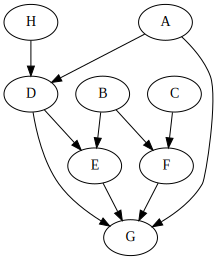

In [7]:
model = from_yaml('clgaussian.yaml')
model.write_dot('clgaussian.dot')
graphviz.Source.from_file('clgaussian.dot')

## Training
Learn the parameters using SVI.

In [8]:
adam = Adam({'lr': 0.005, 'betas': (0.95, 0.995)})

In [9]:
loss=model.train(
    dataset=train_dataset,
    optimizer=adam,
    num_steps=20000,
)

 10%|▉         | 1998/20000 [00:39<05:49, 51.55it/s]svi_step: 2000
elbo: 52474.9381390214
 20%|█▉        | 3994/20000 [01:19<05:08, 51.85it/s]svi_step: 4000
elbo: 24281.874556064606
 30%|██▉       | 5997/20000 [01:59<04:29, 52.02it/s]svi_step: 6000
elbo: 16687.956416249275
 40%|███▉      | 7998/20000 [02:41<04:07, 48.46it/s]svi_step: 8000
elbo: 16448.20926940441
 50%|████▉     | 9996/20000 [03:22<03:12, 51.91it/s]svi_step: 10000
elbo: 16313.563442468643
 60%|█████▉    | 11997/20000 [04:01<02:34, 51.88it/s]svi_step: 12000
elbo: 16250.251481175423
 70%|██████▉   | 13996/20000 [04:40<01:56, 51.71it/s]svi_step: 14000
elbo: 16261.04537087679
 80%|███████▉  | 15998/20000 [05:19<01:17, 51.86it/s]svi_step: 16000
elbo: 16252.376795172691
 90%|████████▉ | 17997/20000 [05:58<00:39, 51.25it/s]svi_step: 18000
elbo: 16297.103867650032
100%|█████████▉| 19994/20000 [06:37<00:00, 50.86it/s]svi_step: 20000
elbo: 16256.185936391354
100%|██████████| 20000/20000 [06:37<00:00, 50.29it/s]
training time: 397.

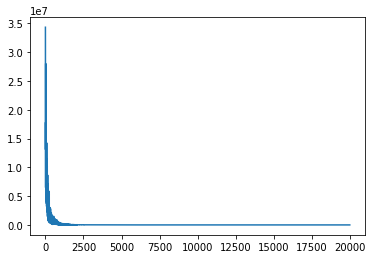

In [10]:
axes = plt.gca()
plt.plot(loss)

## Verify learned parameters
Let us compare the parameters learned using the bnlearn R package and those of the model.

In [11]:
# CPD over A is Cat(0.0948, 0.9052 )
alphas = model.get_node_object('A').guide_alpha
print(alphas / torch.sum(alphas, dim=-1, keepdim=True))

tensor([0.0961, 0.9039], grad_fn=<DivBackward0>)


In [12]:
# CPD over B is Cat(0.4098 0.1882 0.4020)
alphas = model.get_node_object('B').guide_alpha
print(alphas / torch.sum(alphas, dim=-1, keepdim=True))

tensor([0.4109, 0.1799, 0.4092], grad_fn=<DivBackward0>)


In [13]:
# CPD over C is Cat(0.2492 0.2506 0.3984 0.1018)
alphas = model.get_node_object('C').guide_alpha
print(alphas / torch.sum(alphas, dim=-1, keepdim=True))

tensor([0.2529, 0.2519, 0.3925, 0.1027], grad_fn=<DivBackward0>)


In [14]:
# CPD over D
# N(5.2919300 + H * 0.8817193, 0.5099208) when A=a
# N(10.0410549 + H * 0.9834474, 0.3073215) when A=b
node_object = model.get_node_object('D')
bias = node_object.guide_bias_mean
weights = node_object.guide_weights_mean
scale = node_object.guide_scale_scale
print(bias)
print(weights)
print(scale)

tensor([4.8389, 9.9357], requires_grad=True)
tensor([[1.0684],
        [1.0254]], requires_grad=True)
tensor([0.5010, 0.3078], grad_fn=<AddBackward0>)


In [15]:
# CPD over E
# N(0.9953554 + 2.3516060 * D, 0.5084347) when B=a
# N(4.3440402 + 1.1510685 * D, 0.9916523) when B=b
# N(7.9191636 + 0.6742652 * D, 1.5191395) when B=c
node_object = model.get_node_object('E')
bias = node_object.guide_bias_mean
weights = node_object.guide_weights_mean
scale = node_object.guide_scale_scale
print(bias)
print(weights)
print(scale)

tensor([0.9963, 4.4288, 7.9967], requires_grad=True)
tensor([[2.3517],
        [1.1392],
        [0.6631]], requires_grad=True)
tensor([0.5071, 1.0036, 1.5179], grad_fn=<AddBackward0>)


In [16]:
# CPD over F
# Cat([
#         [
#             [0.07875458, 0.92124542], 
#             [0.45525292, 0.54474708], 
#             [0.67905824, 0.32094176], 
#             [0.85714286, 0.14285714]
#         ], 
#         [
#             [0.14977974, 0.85022026], 
#             [0.26293103, 0.73706897], 
#             [0.42297650, 0.57702350], 
#             [0.45454545, 0.54545455]
#         ], 
#         [
#             [0.51162791, 0.48837209], 
#             [0.47731755, 0.52268245], 
#             [0.74937656, 0.25062344], 
#             [0.73684211, 0.26315789]
#         ]
#     ]
# )
alphas = model.get_node_object('F').guide_alpha
print(alphas / torch.sum(alphas, dim=-1, keepdim=True))

tensor([[[0.0866, 0.9134],
         [0.4618, 0.5382],
         [0.7031, 0.2969],
         [0.8486, 0.1514]],

        [[0.1579, 0.8421],
         [0.2833, 0.7167],
         [0.4156, 0.5844],
         [0.4428, 0.5572]],

        [[0.5234, 0.4766],
         [0.4836, 0.5164],
         [0.7526, 0.2474],
         [0.7299, 0.2701]]], grad_fn=<DivBackward0>)


In [17]:
# CPD over G
# N(4.949135 + 2.252665 * D + 1.002022 * E, 0.05456809) when A=a, F=a
# N(3.485634 + 2.989924 * D + 1.003836 * E, 0.26272612) when A=a, F=b
# N(2.384710 + 4.066430 * D + 1.000199 * E, 0.14946301) when A=b, F=a
# N(2.140170 + 5.806728 * D + 1.001002 * E, 0.35182957) When A=b, F=b
node_object = model.get_node_object('G')
bias = node_object.guide_bias_mean
weights = node_object.guide_weights_mean
scale = node_object.guide_scale_scale
print(bias)
print(weights)
print(scale)

tensor([[4.9459, 3.6304],
        [2.4588, 2.8089]], requires_grad=True)
tensor([[[2.2537, 1.0026],
         [2.9707, 1.0024]],

        [[4.0600, 1.0007],
         [5.7535, 1.0000]]], requires_grad=True)
tensor([[0.0596, 0.2591],
        [0.1496, 0.3553]], grad_fn=<AddBackward0>)


## Predictions
Let us predict the variable 'A' given the values of other variables.

In [18]:
_, map_assignment, _ = model.predict(
    dataset=test_dataset,
    target_variables=['A']
)
acc = float(torch.eq(map_assignment['A'], test_dataset['A']).sum()) / len(test_dataset)
print(f'accuracy is {acc}')

accuracy is 1.0
